# Futures Premium Analysis
Download and analyze futures data to understand the premium or discount of futures contracts compared to their underlying assets.  
All codes to download data are written in ts_helper.py using tushare.  
Tushare is a financial data provider in China, which requires a token for access.  
Too run this notebook, you should either set token in .env or put pre-downloaded feather files in data directory.

In [151]:
import sys
from numpy import NaN
import time
import math
from ts_helper import *
import requests
from tqdm import tqdm
from matplotlib import pyplot as plt
import statsmodels.api as sm_api
from stargazer.stargazer import Stargazer
import warnings

warnings.filterwarnings("ignore")

start_date = '20200101'
end_date = '20250813'
futures = get_future_basic(exchange='CFFEX')
sorted_indexes = ['IH', 'IF', 'IC', 'IM']

indexes = {
    'IC': get_index_daily(ts_code='000905.SH', start_date='20200101', end_date=end_date).sort_index(),
    'IF': get_index_daily(ts_code='000300.SH', start_date='20200101', end_date=end_date).sort_index(),
    'IM': get_index_daily(ts_code='000852.SH', start_date='20200101', end_date=end_date).sort_index(),
    'IH': get_index_daily(ts_code='000016.SH', start_date='20200101', end_date=end_date).sort_index(),
}

groups = {
    'IC': dict(prefix='IC', index='000905.SH', chinese_name='中证500指数'),
    'IF': dict(prefix='IF', index='000300.SH', chinese_name='沪深300指数'),
    'IM': dict(prefix='IM', index='000852.SH', chinese_name='中证1000指数'),
    'IH': dict(prefix='IH', index='000016.SH', chinese_name='上证50指数'),
}

filtered_futures = futures[(futures['list_date'] <= end_date) & (futures['delist_date'] >= start_date)]
df_future_panel = get_future_daily(filtered_futures['ts_code'].tolist(), start_date, end_date)

filtered_futures['delist'] = pd.to_datetime(filtered_futures['delist_date'], format='%Y%m%d')
delist_map = dict(zip(filtered_futures['ts_code'], filtered_futures['delist']))
df_future_panel['trade_date'] = pd.to_datetime(df_future_panel['trade_date'], format='%Y%m%d')
df_future_panel['delist'] = df_future_panel['ts_code'].apply(lambda x: delist_map.get(x, pd.NaT))
df_future_panel['rest_life'] = (df_future_panel['delist'] - df_future_panel['trade_date']).dt.days
df_future_panel.set_index(['trade_date'], inplace=True)
df_future_panel = df_future_panel[df_future_panel['rest_life'] > 5]
df_close_future = df_future_panel.reset_index().pivot(index='trade_date', columns='ts_code', values='close').sort_index()
df_oi_future = df_future_panel.reset_index().pivot(index='trade_date', columns='ts_code', values='oi').sort_index()
df_rest_future = df_future_panel.reset_index().pivot(index='trade_date', columns='ts_code', values='rest_life').sort_index()

def get_future_premium_rate(index_name, start='2023-01-01', end=end_date):
    group = groups[index_name]
    index_df = indexes[index_name]
    future_df = df_close_future.filter(like=group['prefix']).sort_index()
    rest_life_df = df_rest_future.filter(like=group['prefix']).sort_index()
    filter_index = index_df.loc[start:end]
    filter_future = future_df.loc[start:end].dropna(axis=1, how='all')
    filter_rest_life = rest_life_df.loc[start:end].dropna(axis=1, how='all')

    future_premium = filter_future.subtract(filter_index['close'], axis=0)
    future_premium_rate = filter_future.divide(filter_index['close'], axis=0).apply(lambda x: x.apply(lambda y: math.log(y) if y else NaN))
    future_premium_rate = (future_premium_rate / filter_rest_life) * 365
    future_premium_rate = future_premium_rate.apply(lambda x: x.apply(lambda y: math.exp(y) - 1 if y else NaN))
    return future_premium, future_premium_rate

def plot_future_premium(index_name, start='2023-01-01', end=end_date):
    future_premium, future_premium_rate = get_future_premium_rate(index_name, start, end)
    future_premium.plot(title=f"{index_name} Futures Premium", figsize=(24, 6))
    future_premium_rate.loc[start:end].dropna(how='all', axis=1).plot(title=f"{index_name} Futures Premium Rate", figsize=(24, 6), grid=True)
    
def get_premium_index(plot=False):
    """weighted average of premium rate for all futures in the index
    The weight is the open interest of each future contract.
    The premium rate is the log return of the future price divided by the remaining life of the contract in days.
    """
    series = {}
    for index_name, group in groups.items():
        _, future_premium_rate = get_future_premium_rate(index_name, start_date, end_date)
        filtered_oi_future = df_oi_future.filter(like=group['prefix']).sort_index()
        filtered_oi_future = filtered_oi_future.loc[future_premium_rate.index]
        premium_index = (filtered_oi_future * future_premium_rate).dropna(how='all', axis=0).sum(axis=1) / filtered_oi_future.sum(axis=1)
        series[index_name] = premium_index
    return pd.DataFrame(series)

premium_index = get_premium_index()
df_fund_basic = get_enhanced_index_fund_basic()
df_fund_nav = get_enhanced_index_fund_nav(start_date, end_date)
df_index_log_return = pd.DataFrame({
    _index_name: _df.close.apply(np.log) - _df.pre_close.apply(np.log)
    for _index_name, _df in indexes.items()
}).sort_index()
df_index_forward_log_return = df_index_log_return.shift(-1).dropna(how='all', axis=0)
df_index_forward_5days_log_return = df_index_log_return.rolling(window=5).sum().shift(-5).dropna(how='all', axis=0)
df_index_forward_30days_log_return = df_index_log_return.rolling(window=30).sum().shift(-30).dropna(how='all', axis=0)

def delete_outliers(df):
    """delete data from 2024-09-20 to 2024-10-15"""
    return df.loc[~df.index.to_series().between('2024-09-20', '2024-10-15')]

# A. Basic Data Insights

In [ ]:
# basic future info
filtered_futures.T

,4,8,9,10,11,12,14,15,18,25,...,600,604,606,607,608,609,610,612,613,614
ts_code,IM2505.CFX,T2112.CFX,TF2112.CFX,TS2112.CFX,IC2505.CFX,IF2402.CFX,IM2306.CFX,IF2403.CFX,IH2402.CFX,TF2412.CFX,...,IC2603.CFX,T2506.CFX,TF2212.CFX,IF2409.CFX,IC2412.CFX,IF2308.CFX,IM2408.CFX,IC2203.CFX,IF2203.CFX,IH2203.CFX
symbol,IM2505,T2112,TF2112,TS2112,IC2505,IF2402,IM2306,IF2403,IH2402,TF2412,...,IC2603,T2506,TF2212,IF2409,IC2412,IF2308,IM2408,IC2203,IF2203,IH2203
exchange,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,...,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX,CFFEX
name,IM2505,T2112,TF2112,TS2112,IC2505,IF2402,IM2306,IF2403,IH2402,TF2412,...,IC2603,T2506,TF2212,IF2409,IC2412,IF2308,IM2408,IC2203,IF2203,IH2203
fut_code,IM,T,TF,TS,IC,IF,IM,IF,IH,TF,...,IC,T,TF,IF,IC,IF,IM,IC,IF,IH
multiplier,200.0,10000.0,10000.0,20000.0,200.0,300.0,200.0,300.0,300.0,10000.0,...,200.0,10000.0,10000.0,300.0,200.0,300.0,200.0,200.0,300.0,300.0
trade_unit,张,张,张,张,张,张,张,张,张,张,...,张,张,张,张,张,张,张,张,张,张
per_unit,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
quote_unit,指数点,人民币元,人民币元,人民币元,指数点,指数点,指数点,指数点,指数点,人民币元,...,指数点,人民币元,人民币元,指数点,指数点,指数点,指数点,指数点,指数点,指数点
quote_unit_desc,0.2指数点,0.005人民币元,0.005人民币元,0.002人民币元,0.2指数点,0.2指数点,0.2指数点,0.2指数点,0.2指数点,0.005人民币元,...,0.2指数点,0.005人民币元,0.005人民币元,0.2指数点,0.2指数点,0.2指数点,0.2指数点,0.2指数点,0.2指数点,0.2指数点


<AxesSubplot:title={'center':'IC Index'}, xlabel='trade_date'>

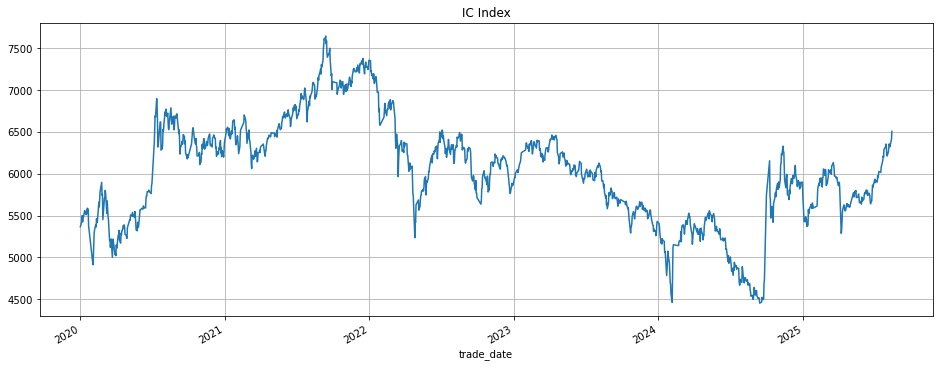

In [ ]:
# index price
indexes['IC'].close.plot(title='IC Index', figsize=(16, 6), grid=True)

In [137]:
df_index_forward_log_return
# df_index_forward_5days_log_return
# df_index_forward_30days_log_return

,IC,IF,IM,IH
trade_date,,,,
2020-01-02,0.002698,-0.001754,0.005181,-0.004070
2020-01-03,0.010025,-0.003788,0.010233,-0.006990
2020-01-06,0.011887,0.007463,0.015086,0.005604
2020-01-07,-0.013923,-0.011583,-0.013744,-0.011834
2020-01-08,0.013505,0.012578,0.015762,0.009727
...,...,...,...,...
2025-08-06,-0.003125,0.000287,0.000123,0.000317
2025-08-07,-0.002218,-0.002360,-0.003506,-0.003270
2025-08-08,0.010737,0.004265,0.015355,0.000259


In [139]:
df_fund_basic.T

,31,33,39,40,47,60,61,64,65,70,...,14651,14685,14693,14698,14700,14703,14757,14758,14829,14837
ts_code,023938.OF,023937.OF,023419.OF,023418.OF,159226.SZ,023608.OF,023607.OF,023914.OF,023913.OF,023562.OF,...,005530.OF,010202.OF,010356.OF,010352.OF,010203.OF,010355.OF,009608.OF,009609.OF,010154.OF,010153.OF
name,苏新上证科创综指增强C,苏新上证科创综指增强A,宏利中证A50指数增强C,宏利中证A50指数增强A,中证A500增强ETF,光大沪深300指数增强C,光大沪深300指数增强A,富国上证科创板综合价格指数增强C,富国上证科创板综合价格指数增强A,广发中证800指数增强A,...,汇添富沪深300指数增强A,天弘中证科技100指数增强A,诺安创业板指数增强C,诺安沪深300指数增强C,天弘中证科技100指数增强C,诺安中证500指数增强C,广发中证500指数增强A,广发中证500指数增强C,中加中证500指数增强C,中加中证500指数增强A
management,苏新基金,苏新基金,宏利基金,宏利基金,国泰基金,光大保德信基金,光大保德信基金,富国基金,富国基金,广发基金,...,汇添富基金,天弘基金,诺安基金,诺安基金,天弘基金,诺安基金,广发基金,广发基金,中加基金,中加基金
custodian,华鑫证券,华鑫证券,交通银行,交通银行,中国工商银行,建设银行,建设银行,建设银行,建设银行,财通证券,...,建设银行,国泰海通,中国银行,中国工商银行,国泰海通,中国银行,中国银行,中国银行,中信建投证券,中信建投证券
fund_type,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型,...,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型,股票型
found_date,20250520,20250520,20250520,20250520,20250520,20250516,20250516,20250516,20250516,20250515,...,20201103,20201028,20201028,20201028,20201028,20201028,20201015,20201015,20200927,20200927
due_date,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
list_date,None,None,None,None,20250529,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
issue_date,20250414,20250414,20250421,20250421,20250401,20250421,20250421,20250421,20250421,20250407,...,20201103,20201012,None,None,20201012,None,20200729,20200729,20200914,20200914
delist_date,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [144]:
df_fund_nav.T

,0,1,2,3,4,5,6,7,8,9,...,266329,266330,266331,266332,266333,266334,266335,266336,266337,266338
ts_code,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,023938.OF,...,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF,010153.OF
ann_date,20250814,20250813,20250812,20250809,20250808,20250807,20250806,20250805,20250802,20250801,...,20201128,20201121,20201114,20201107,20201031,20201024,20201017,20201010,20201001,20200928
nav_date,20250813,20250812,20250811,20250808,20250807,20250806,20250805,20250804,20250801,20250731,...,20201127,20201120,20201113,20201106,20201030,20201023,20201016,20201009,20200930,20200927
unit_nav,1.2045,1.1878,1.1804,1.1602,1.1688,1.1719,1.1645,1.1591,1.1446,1.1435,...,0.963,0.9748,0.9665,0.9754,0.9667,0.9727,0.998,1.0021,1.0004,1.0
accum_nav,1.2045,1.1878,1.1804,1.1602,1.1688,1.1719,1.1645,1.1591,1.1446,1.1435,...,0.963,0.9748,0.9665,0.9754,0.9667,0.9727,0.998,1.0021,1.0004,1.0
accum_div,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
net_asset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96019344.11
total_netasset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204983003.67
adj_nav,1.2045,1.1878,1.1804,1.1602,1.1688,1.1719,1.1645,1.1591,1.1446,1.1435,...,0.963,0.9748,0.9665,0.9754,0.9667,0.9727,0.998,1.0021,1.0004,1.0
update_flag,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# B. Future Premium Insights

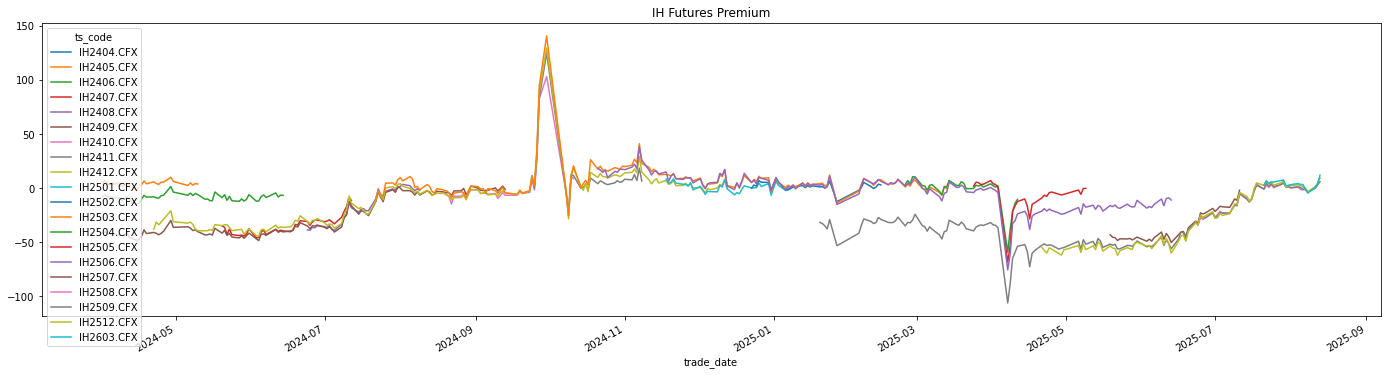

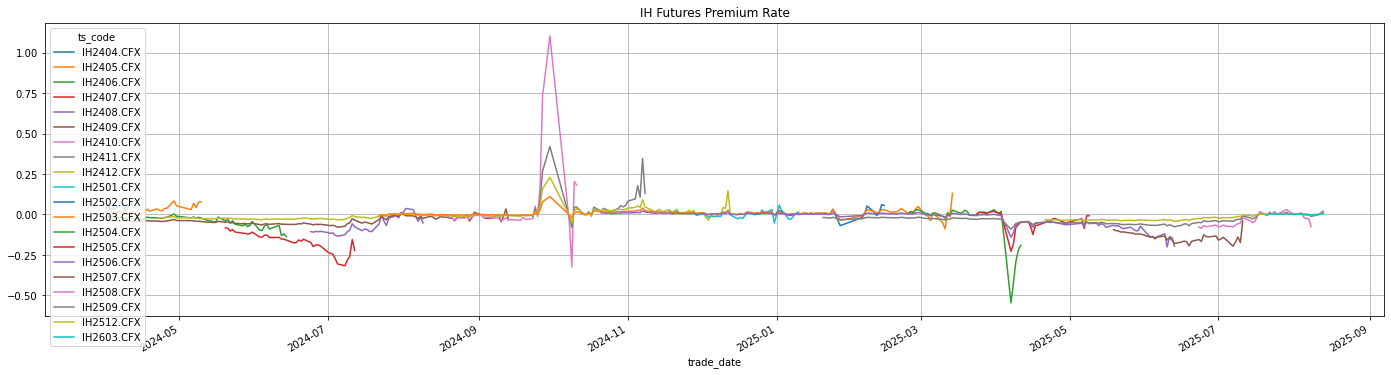

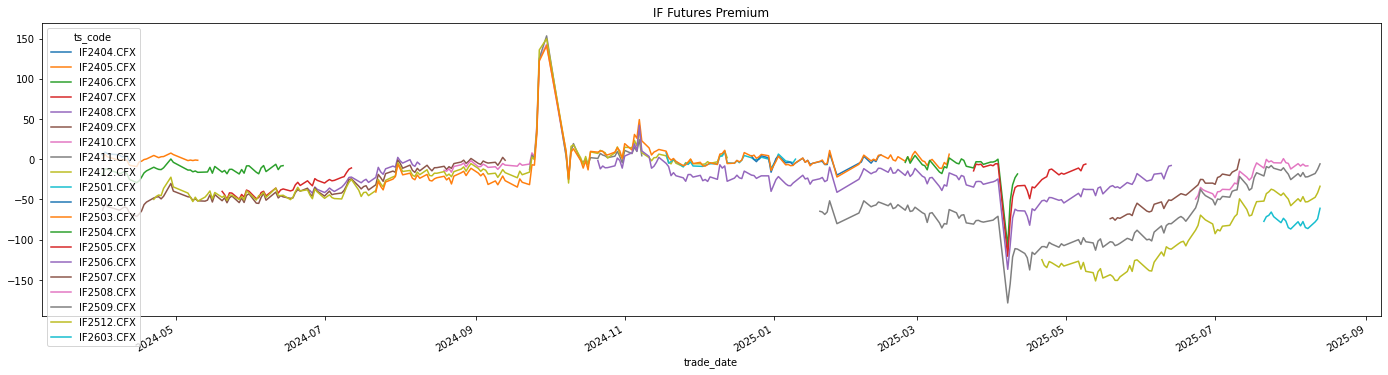

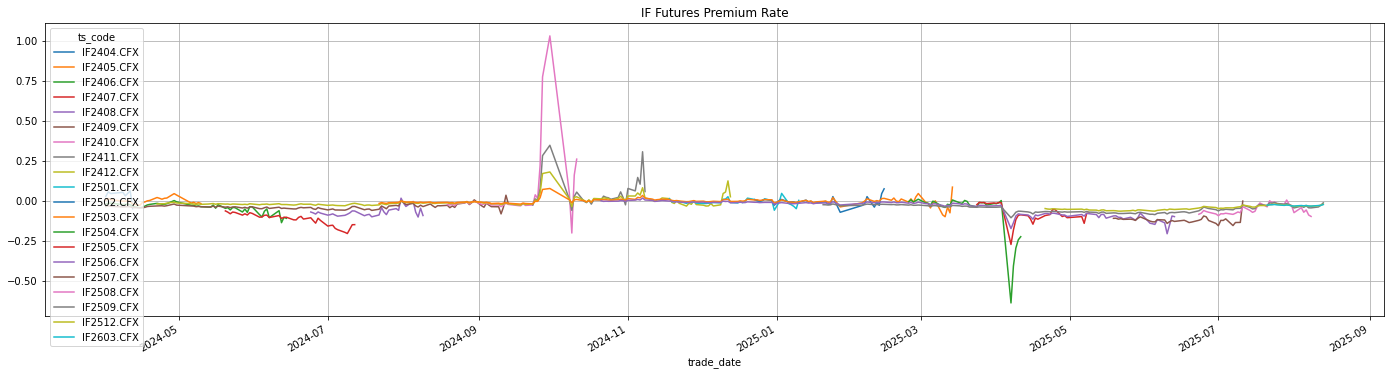

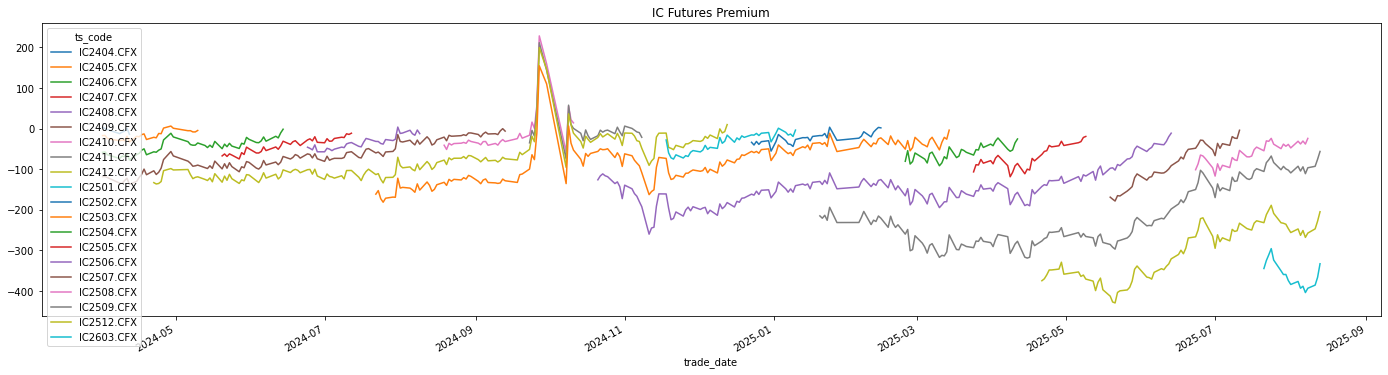

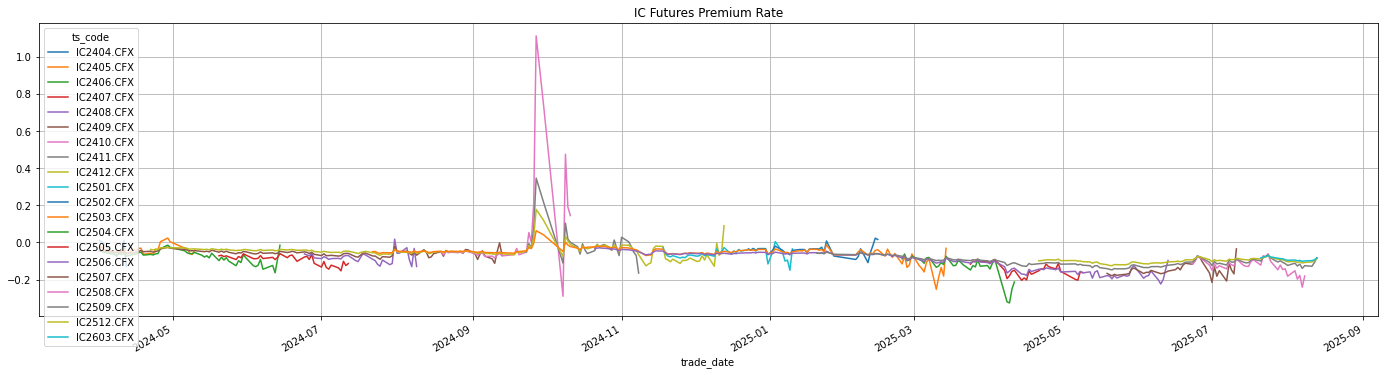

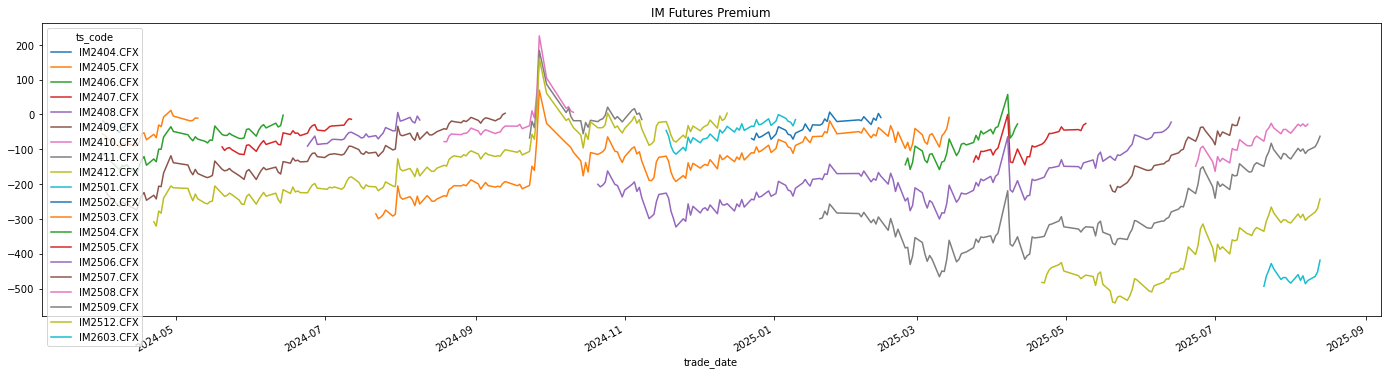

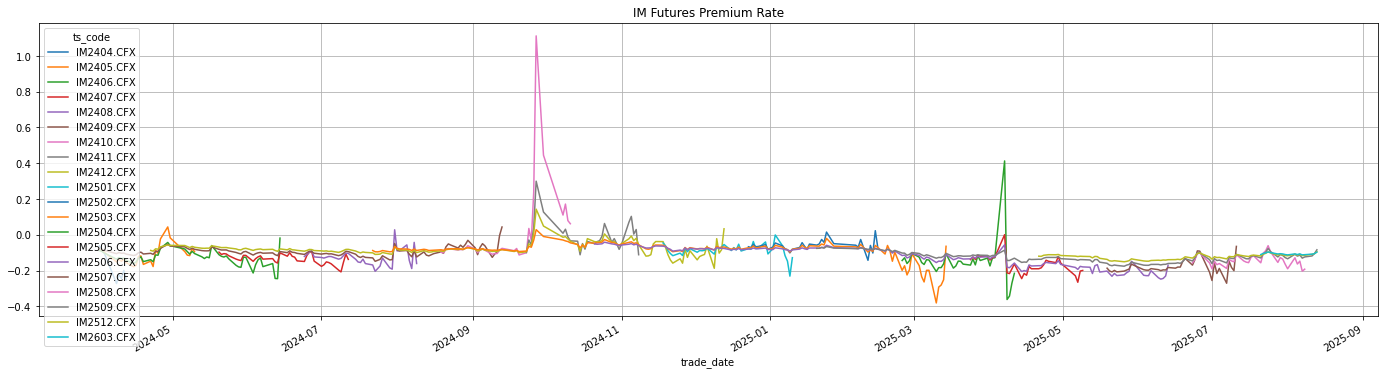

In [152]:
plot_future_premium('IH', start='2024-04-01')
plot_future_premium('IF', start='2024-04-01')
plot_future_premium('IC', start='2024-04-01')
plot_future_premium('IM', start='2024-04-01')

<AxesSubplot:title={'center':'Premium Index 2023~2025'}, xlabel='trade_date'>

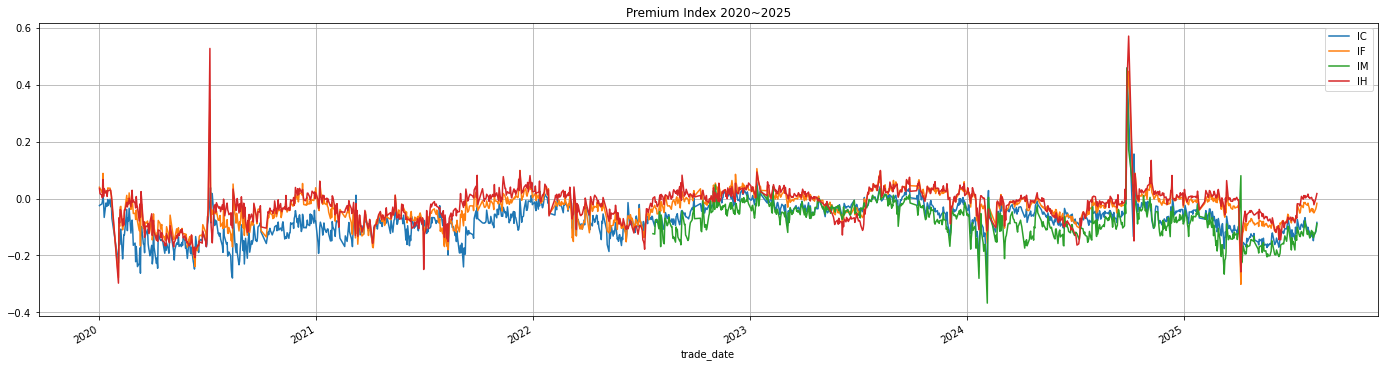

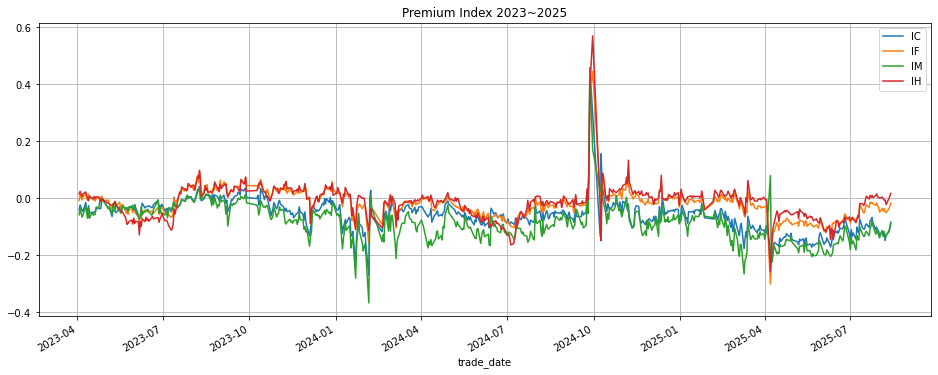

In [146]:
premium_index.plot(title='Premium Index 2020~2025', figsize=(24, 6), grid=True)
premium_index.loc['2023-04-01':].plot(title='Premium Index 2023~2025', figsize=(16, 6), grid=True)

# C. Future Premium Rate & Fund Alpha Analysis

In [160]:
def fit_fund_coef(index_name, start_date=start_date, end_date=end_date):
    group = groups[index_name]
    selected_funds = df_fund_basic[df_fund_basic.benchmark.apply(lambda x: group['chinese_name'] in x)]
    selected_funds = selected_funds[selected_funds.found_date <= '2023-01-01']
    selected_funds = selected_funds[selected_funds.status == 'L']
    selected_funds = selected_funds[selected_funds.name.apply(lambda x: not x.endswith('C'))] # exclude C class funds
    model_results = []
    for fund_ts_code in selected_funds.ts_code.tolist():
        filtered_nav = df_fund_nav[df_fund_nav.ts_code == fund_ts_code]
        fund_size = filtered_nav['total_netasset'].dropna().median()
        filtered_nav.set_index(pd.to_datetime(filtered_nav.nav_date), inplace=True)
        filtered_nav.sort_index(inplace=True)
        filtered_nav = filtered_nav.loc[start_date:end_date]
        _nav = -filtered_nav.filter(['accum_nav']).apply(np.log).diff(-1).dropna()
        if len(_nav.index) < 20:
            print(f"Not enough data for fund {fund_ts_code} ({selected_funds[selected_funds.ts_code == fund_ts_code].name.values[0]})")
            continue
        _nav['index_return'] = df_index_forward_log_return[index_name]
        _nav.dropna(inplace=True)
        _nav = delete_outliers(_nav)
        X = _nav['index_return']
        Y = _nav['accum_nav']
        X = sm_api.add_constant(X)
        model = sm_api.OLS(Y, X).fit()
        model_results.append({
            'index_name': index_name,
            'ts_code': fund_ts_code,
            'name': selected_funds[selected_funds.ts_code == fund_ts_code].name.values[0],
            'size': fund_size,
            'alpha': model.params['const'],  # daily alpha
            'alpha_annual': model.params['const'] * 252,  # annualized alpha
            'beta': model.params['index_return'],
            'r_squared': model.rsquared,
            'alpha_p_value': model.pvalues['const'],
        })
    return pd.DataFrame(model_results)
    
models_results = pd.concat([
    fit_fund_coef('IC'),
    fit_fund_coef('IF'),
    fit_fund_coef('IM'),
    fit_fund_coef('IH'),
], ignore_index=True)

models_results

,index_name,ts_code,name,size,alpha,alpha_annual,beta,r_squared,alpha_p_value
0,IC,016267.OF,建信中证500指数量化增强A,1.673974e+08,0.000049,0.012453,0.863286,0.934197,0.657666
1,IC,015507.OF,兴业中证500指数增强A,9.819937e+07,0.000151,0.037950,0.867521,0.921896,0.169856
2,IC,014587.OF,华安中证500指数增强A,6.435302e+07,-0.000140,-0.035269,0.865360,0.914885,0.219170
3,IC,015453.OF,中欧中证500指数增强A,2.519065e+08,0.000006,0.001442,0.836842,0.900753,0.961574
4,IC,014305.OF,华泰柏瑞中证500指数增强A,9.940929e+07,0.000071,0.017810,0.793469,0.879703,0.581162
5,IC,560100.SH,中证500增强ETF,1.146434e+08,0.000146,0.036677,0.912277,0.952405,0.101440
6,IC,014344.OF,鹏华中证500指数增强A,2.223182e+08,0.000291,0.073216,0.864337,0.930084,0.004776
7,IC,014155.OF,国泰君安中证500A,1.672692e+09,0.000290,0.073171,0.933780,0.952799,0.001072
8,IC,014133.OF,工银中证500六个月持有指数增强A,2.051449e+08,0.000139,0.035105,0.894226,0.946647,0.124616
9,IC,159610.SZ,500ETF增强,6.305350e+08,0.000042,0.010484,0.903687,0.945592,0.654033


In [159]:
print('alpha median for all funds:')
display(models_results.groupby('index_name').alpha_annual.describe().sort_values('50%'))
print('alpha median for funds with p-value < 0.1:')
display(models_results.query('alpha_p_value < 0.1').groupby('index_name').alpha_annual.describe().sort_values('50%'))

alpha median for all funds:


,count,mean,std,min,25%,50%,75%,max
index_name,,,,,,,,
IH,1.0,0.017404,NaN,0.017404,0.017404,0.017404,0.017404,0.017404
IC,21.0,0.019838,0.030258,-0.035269,-0.003763,0.018128,0.036677,0.073216
IF,18.0,0.014176,0.025632,-0.047829,0.009409,0.019240,0.024932,0.053515
IM,16.0,0.053430,0.035365,-0.014600,0.037950,0.049008,0.067015,0.120825


alpha median for funds with p-value < 0.1:


,count,mean,std,min,25%,50%,75%,max
index_name,,,,,,,,
IF,3.0,0.044440,0.008280,0.037297,0.039903,0.042509,0.048012,0.053515
IC,4.0,0.065094,0.011887,0.048008,0.061487,0.069575,0.073182,0.073216
IM,8.0,0.077158,0.028044,0.045027,0.054767,0.073838,0.096382,0.120825


In [ ]:
# time rolling analysis
date_ranges = [
    ('2023-01-01', '2023-03-01'),
    ('2023-03-01', '2023-05-01'),
    ('2023-05-01', '2023-07-01'),
    ('2023-07-01', '2023-09-01'),
    ('2023-09-01', '2023-11-01'),
    ('2023-11-01', '2024-01-01'),
    ('2024-01-01', '2024-03-01'),
    ('2024-03-01', '2024-05-01'),
    ('2024-05-01', '2024-07-01'),
    ('2024-07-01', '2024-09-01'),
    ('2024-09-01', '2024-11-01'),
    ('2024-11-01', '2025-01-01'),
    ('2025-01-01', '2025-03-01'),
    ('2025-03-01', '2025-05-01'),
    ('2025-05-01', '2025-07-01'),
    ('2025-07-01', '2025-09-01'),
]
results = []
for start, end in tqdm(date_ranges):
    _models_results = pd.concat([
        fit_fund_coef('IH', start_date=start, end_date=end),
        fit_fund_coef('IF', start_date=start, end_date=end),
        fit_fund_coef('IC', start_date=start, end_date=end),
        fit_fund_coef('IM', start_date=start, end_date=end),
    ], ignore_index=True)
    _models_results['date_range_start'] = pd.to_datetime(start)
    results.append(_models_results)
df_rolling_results = pd.concat(results, ignore_index=True)
df_rolling_results

  6%|▋         | 1/16 [00:00<00:08,  1.80it/s]

Not enough data for fund 016785.OF (鹏华中证1000指数增强A)


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


,index_name,ts_code,name,size,alpha,alpha_annual,beta,r_squared,alpha_p_value,date_range_start
0,IH,012157.OF,汇添富上证50基本面增强A,5.312004e+07,-0.000539,-0.135952,0.956987,0.981445,0.019481,2023-01-01
1,IF,017445.OF,摩根沪深300指数增强A,1.573544e+07,0.000182,0.045846,0.960816,0.925354,0.714013,2023-01-01
2,IF,016103.OF,申万菱信沪深300优选指数增强A,1.289405e+07,-0.000710,-0.178895,0.863783,0.968537,0.017381,2023-01-01
3,IF,005850.OF,财通沪深300指数增强,2.733830e+08,0.000197,0.049756,0.415809,0.461814,0.689933,2023-01-01
4,IF,561000.SH,沪深300ETF增强基金,1.287392e+08,-0.000160,-0.040235,0.883554,0.905480,0.750525,2023-01-01
...,...,...,...,...,...,...,...,...,...,...
890,IM,015495.OF,景顺长城中证1000指数增强A,1.390374e+08,0.000608,0.153328,0.890252,0.967341,0.013749,2025-07-01
891,IM,014831.OF,兴银中证1000指数增强A,2.238353e+08,0.000593,0.149334,0.898374,0.966778,0.017936,2025-07-01
892,IM,014201.OF,天弘中证1000指数增强A,8.402306e+08,0.000915,0.230682,0.839633,0.917616,0.015725,2025-07-01
893,IM,014125.OF,华夏中证1000指数增强A,9.698916e+08,0.000535,0.134748,0.785317,0.896895,0.167387,2025-07-01


index_name,IC,IF,IH,IM
date_range_start,,,,
2023-01-01,0.017552,-0.093072,-0.135952,0.144193
2023-03-01,-0.227114,-0.256463,NaN,-0.240279
2023-05-01,0.037117,-0.183283,NaN,0.139668
2023-07-01,0.105585,0.095936,NaN,0.126406
2023-09-01,-0.012939,-0.144693,NaN,-0.112977
2023-11-01,0.085400,0.114409,NaN,0.159365
2024-01-01,0.121131,-0.051129,NaN,0.229852
2024-03-01,-0.302713,0.369313,NaN,-0.273841
2024-05-01,-0.010294,0.030723,NaN,0.166250


<AxesSubplot:xlabel='date_range_start'>

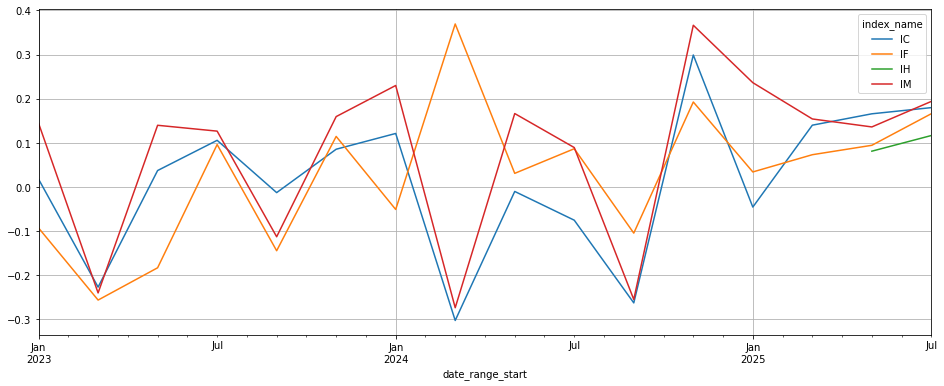

In [179]:
df_rolling_index_alpha = df_rolling_results.query('alpha_p_value < 0.2').groupby(['date_range_start', 'index_name']).alpha_annual.mean().unstack()
display(df_rolling_index_alpha)
df_rolling_index_alpha.plot(figsize=(16, 6), grid=True)

# D. Future Premium Rate Change Predicting forward returns

In [155]:
models = []
columns = []
for index_name in sorted_indexes:
    def fit_model(target):
        X = pd.concat([
            premium_index[index_name].diff(), 
            premium_index[index_name].diff(3),
        ], axis=1, keys=[f'{index_name}-chg-1d', f'{index_name}-chg-3d']).dropna()
        _start_date = X.index.min()
        _end_date = X.index.max()
        Y = delete_outliers(target[index_name].loc[_start_date:_end_date].dropna())
        X = X.loc[Y.index]
        X = sm_api.add_constant(X)
        model = sm_api.OLS(Y, X).fit()
        models.append(model)
    fit_model(df_index_forward_log_return)
    fit_model(df_index_forward_5days_log_return)
    fit_model(df_index_forward_30days_log_return)
    columns.extend([f"{index_name}-rtn-1d", f"{index_name}-rtn-5d", f"{index_name}-rtn-30d"])

stargazer = Stargazer(models)
stargazer.custom_columns(columns)
stargazer.title("OLS Regression Results for Index Futures Premium")
stargazer.show_model_numbers(False)
stargazer.show_confidence_intervals(True)
stargazer

# Miscellaneous Notes: not in report

- margin detail changes
- real-time discount
- bond & futures

<AxesSubplot:title={'center':'Margin Detail for IM ETF 512100.SH'}, xlabel='trade_date'>

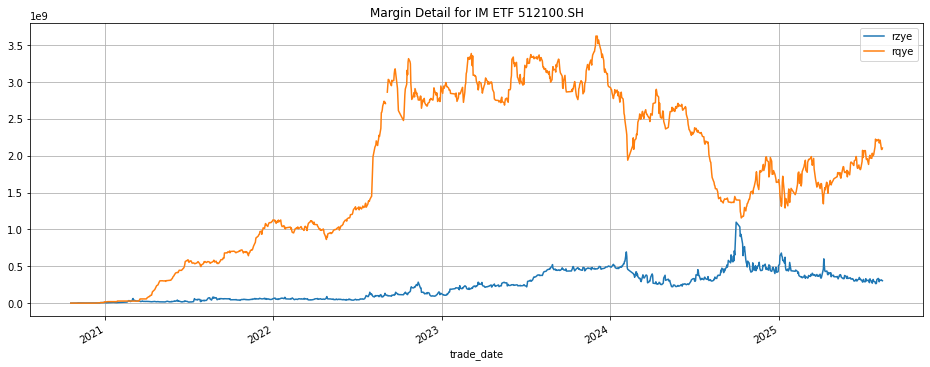

In [126]:
df_margin_detail = get_margin_detail(indexes['IC'].trade_date.tolist())
filtered_margin_detail = df_margin_detail[df_margin_detail.ts_code == '512100.SH']
filtered_margin_detail.set_index(pd.to_datetime(filtered_margin_detail.trade_date, format='%Y%m%d'), inplace=True)
filtered_margin_detail.filter(['rzye', 'rqye']).plot(title='Margin Detail for IM ETF 512100.SH', figsize=(16, 6), grid=True)

In [6]:
# calculate real-time future discount ratio
def get_sinajs_txt(codes):
    headers = {'Referer': 'https://finance.sina.com.cn'}
    url = f'https://hq.sinajs.cn/list={codes}'
    resp = requests.get(url, headers=headers)
    txt = resp.text
    return txt

index_configs = [
    dict(
        code='sh000016',
        name='IH',
    ),
    dict(
        code='sh000300',
        name='IF',
    ),
    dict(
        code='sh000905',
        name='IC',
    ),
    dict(        
        code='sh000852',
        name='IM',
    ),
]
index_map = {index_config['name']: index_config for index_config in index_configs}
today = pd.to_datetime('today').strftime('%Y%m%d')
alive_futures = futures[(futures['list_date'] <= today) & (futures['delist_date'] >= today)].query('exchange == "CFFEX"')
alive_futures
def gen_code(index_config):
    index_code = index_config['code']
    index_name = index_config['name']
    symbols = alive_futures.query(f'fut_code=="{index_name}"').symbol.tolist()
    future_codes = sorted([f'nf_{symbol}' for symbol in symbols])
    return ','.join([index_code, *future_codes])

codes = ','.join([gen_code(index_config) for index_config in index_configs])

txt = get_sinajs_txt(codes)
delist_dates = dict(pd.to_datetime(alive_futures.set_index('symbol').delist_date) + pd.Timedelta(hours=15))
lines = txt.split('\n')
is_index = lambda x: x.startswith('var hq_str_sh')
is_future = lambda x: x.startswith('var hq_str_nf_')

index_data = dict()
future_data = dict()
columns = [
    'name', 'open', 'yclose', 'price', 'high', 'low', 'bid', 'ask', 'volume', 'amount',
    'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v', 'b4', 'b5_v', 'b5',
    'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v', 'a4', 'a5_v', 'a5',
    'date', 'time'
]
futures_columns = [
    'open', 'high', 'low', 'last', 'volume', 'turnover', 'open_interest',
    'close', 'settle', 'limit_up', 'limit_down',
    'prev_settle', 'prev_close',
    'bid1', 'ask1', 'bid1_volume', 'ask1_volume',
    'unknown1',
    'bid2', 'bid2_volume', 'bid3', 'bid3_volume',
    'bid4', 'bid4_volume', 'bid5', 'bid5_volume',
    'ask2', 'ask2_volume', 'ask3', 'ask3_volume',
    'ask4', 'ask4_volume', 'ask5', 'ask5_volume', 'unknowne', 'unknownw',
    'date', 'time', 'unknown2', 'unknown3',
    'empty1','empty2','empty3','empty4','empty5','empty6','empty7','empty8',
    
    'weighted_avg_price', 'name'
]
for line in lines:
    if is_index(line):
        _var, _txt = line.split('="')
        _txt = _txt.strip('";')
        code = _var.split('_')[-1]
        index_data[code] = dict(zip(columns, _txt.split(',')))
    elif is_future(line):
        _var, _txt = line.split('="')
        _txt = _txt.strip('";')
        code = _var.split('_')[-1]
        future_data[code] = dict(zip(futures_columns, _txt.split(',')))
for code, entry in future_data.items():
    index_entry = index_data.get(index_map[code[:2]]['code'], {})
    entry['delist'] = delist_dates.get(code, pd.NaT)
    entry['current_time'] = pd.to_datetime(f"{entry['date']} {entry['time']}", format='%Y-%m-%d %H:%M:%S')
    entry['index_price'] = index_entry['price']
    entry['index_time'] = pd.to_datetime(f"{index_entry['date']} {index_entry['time']}", format='%Y-%m-%d %H:%M:%S')
    entry['rest_days'] = (entry['delist'] - entry['current_time']).total_seconds() / 86400
    entry['ratio'] = math.exp((math.log(float(entry['last'])) - math.log(float(entry['index_price']))) / entry['rest_days'] * 365) - 1 if entry['rest_days'] > 0 else NaN
    entry['ratio_str'] = f"{entry['ratio']:.2%}" if not pd.isna(entry['ratio']) else 'NaN'
    # entry['result']
df_future_data = pd.DataFrame(future_data).T.filter([
    'current_time', 'rest_days', 'delist', 'index_price', 'price', 'last', 'ratio', 'ratio_str',
])
df_future_data.reset_index(inplace=True)
df_future_data.rename(columns={'index': 'symbol'}, inplace=True)
df_future_data['index_name'] = df_future_data['symbol'].apply(lambda x: x[:2])
df_future_data['delist_name'] = df_future_data['symbol'].apply(lambda x: x[2:])
display(df_future_data.pivot(index='delist_name', columns='index_name', values='ratio_str'))
df_future_data['_diff'] = df_future_data['last'].astype(float) - df_future_data['index_price'].astype(float)
df_future_data['_diff_d'] = df_future_data['_diff'] / df_future_data['rest_days']
display(df_future_data.filter(['symbol', 'ratio_str', '_diff', '_diff_d']))

index_name,IC,IF,IH,IM
delist_name,,,,
2508,128.72%,181.74%,9.56%,110.42%
2509,-6.78%,-0.44%,2.05%,-6.53%
2512,-8.16%,-1.75%,0.83%,-8.80%
2603,-8.05%,-2.06%,0.62%,-9.26%


,symbol,ratio_str,_diff,_diff_d
0,IH2508,9.56%,0.1095,0.704925
1,IH2509,2.05%,5.5095,0.156719
2,IH2512,0.83%,8.1095,0.064282
3,IH2603,0.62%,10.3095,0.047475
4,IF2508,181.74%,1.8403,11.848131
5,IF2509,-0.44%,-1.7597,-0.050055
6,IF2512,-1.75%,-25.3597,-0.20102
7,IF2603,-2.06%,-51.3597,-0.236511
8,IC2508,128.72%,2.2932,14.76397
9,IC2509,-6.78%,-43.9068,-1.248937


/var/folders/zd/1nsq3fw56m1_fycw95x25jh40000gn/T/ipykernel_26528/1304720.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_ret = df_close_future.applymap(lambda x: math.log(x)).diff()


<Axes: title={'center': 'IM2512.CFX + TL2512.CFX Log Return'}, xlabel='trade_date'>

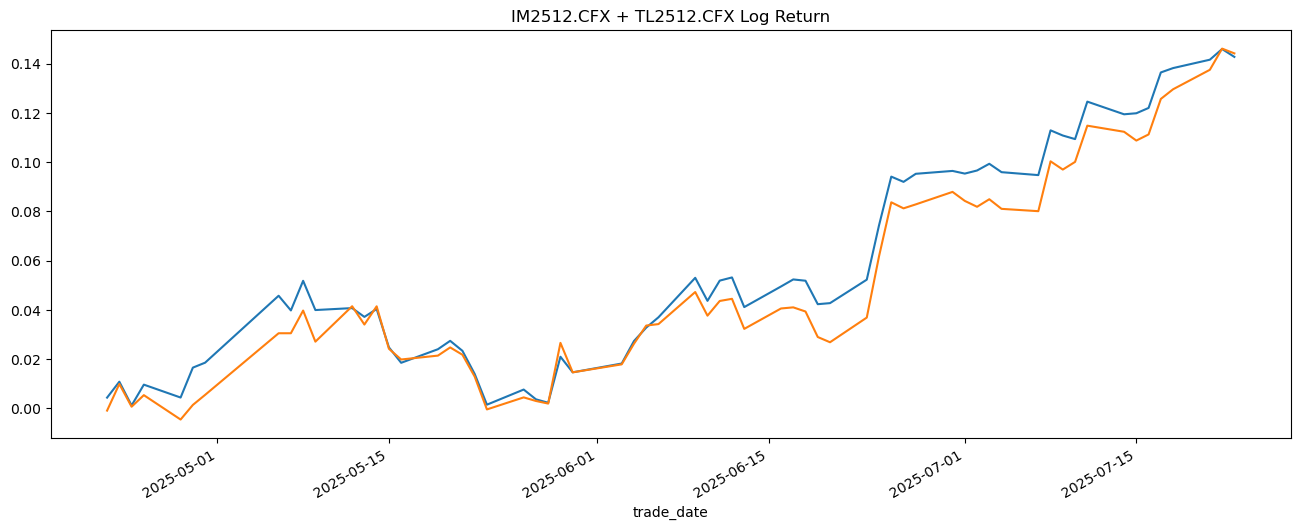

In [ ]:
from statsmodels import api as sm_api
# ret_df = (df_close_future.diff() / df_close_future)
# Y = ret_df['IM2512.CFX'].dropna()
# X = ret_df[['TL2512.CFX', 'T2512.CFX']].dropna()
# X = sm_api.add_constant(X)
# model = sm_api.OLS(Y, X).fit()
# model.summary()

log_ret = df_close_future.applymap(lambda x: math.log(x)).diff()
(log_ret['IM2512.CFX'].cumsum() + log_ret['TL2512.CFX'].cumsum()).plot(title='IM2512.CFX + TL2512.CFX Log Return', figsize=(16, 6), grid=True)
log_ret['IM2512.CFX'].cumsum().plot()

array([[<Axes: xlabel='IM2512.CFX', ylabel='IM2512.CFX'>,
        <Axes: xlabel='T2512.CFX', ylabel='IM2512.CFX'>,
        <Axes: xlabel='TL2512.CFX', ylabel='IM2512.CFX'>],
       [<Axes: xlabel='IM2512.CFX', ylabel='T2512.CFX'>,
        <Axes: xlabel='T2512.CFX', ylabel='T2512.CFX'>,
        <Axes: xlabel='TL2512.CFX', ylabel='T2512.CFX'>],
       [<Axes: xlabel='IM2512.CFX', ylabel='TL2512.CFX'>,
        <Axes: xlabel='T2512.CFX', ylabel='TL2512.CFX'>,
        <Axes: xlabel='TL2512.CFX', ylabel='TL2512.CFX'>]], dtype=object)

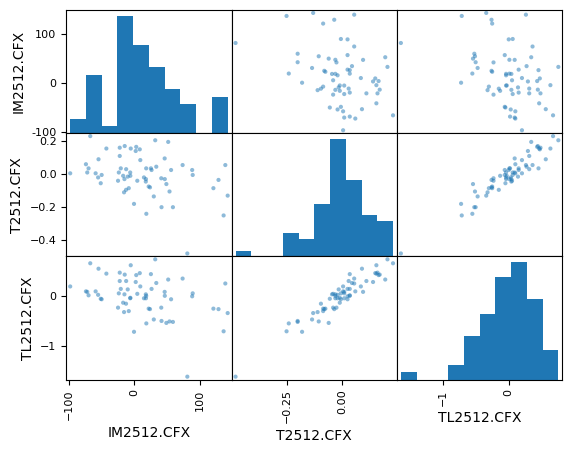

In [32]:
pd.plotting.scatter_matrix(df_close_future.diff().filter(['IM2512.CFX', 'T2512.CFX', 'TL2512.CFX']))